In [42]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import h5py
import os

def load_h5(src_path):
    data = dict()
    with h5py.File(src_path, 'r') as src:
        for key, value in src.items():
            if isinstance(value, h5py.Group):
                data[key] = {k: np.array(v) for k,v in value.items()}
            else:
                data[key] = np.array(value)
        return data
                
src_dir = '../StutRCo/data/RKO_corr'

In [49]:
data = load_h5(os.path.join(src_dir, "info.h5"))

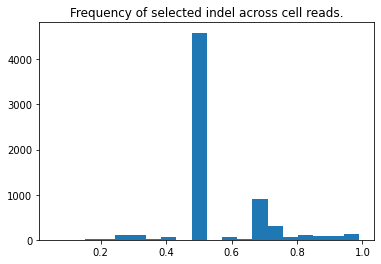

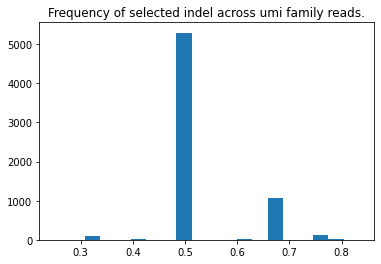

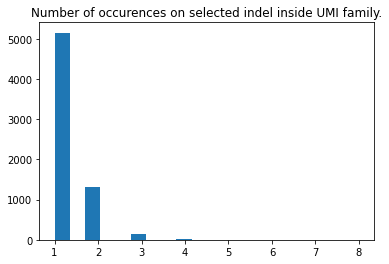

In [23]:
plt.hist(data['cell_freq'], bins=20)
plt.title('Frequency of selected indel across cell reads.')
plt.show()
plt.hist(data['umi_freq'], bins=20)
plt.title('Frequency of selected indel across umi family reads.')
plt.show()
plt.hist(data['umi_count'], bins=20)
plt.title('Number of occurences on selected indel inside UMI family.')
plt.show()

In [65]:
n_reads = dict()
n_umis = dict()
info = data["global"]
for i in range(len(info["chrom"])):
    site = (info["chrom"][i], info["pos"][i])
    n_reads[site] = info["n_reads"][i]
    n_umis[site] = info["n_umi"][i]

In [66]:
df = pd.DataFrame({k:v for k,v in data.items() if k!= "global"})
n_corr_umis = df.groupby(["chrom", "pos"]).size().to_dict()

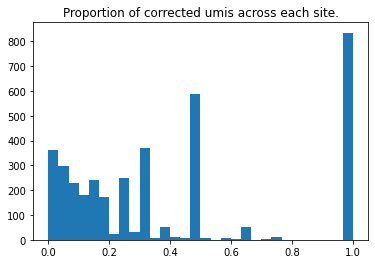

In [72]:
umi_prop = np.array([n_corr_umis[k]/n_umis[k] for k in n_corr_umis if n_umis[k]!=0])
plt.hist(umi_prop, bins=30)
plt.title("Proportion of corrected umis across each site.")
plt.show()